# EJERCICIO 1: Reducción y normalización

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Telco

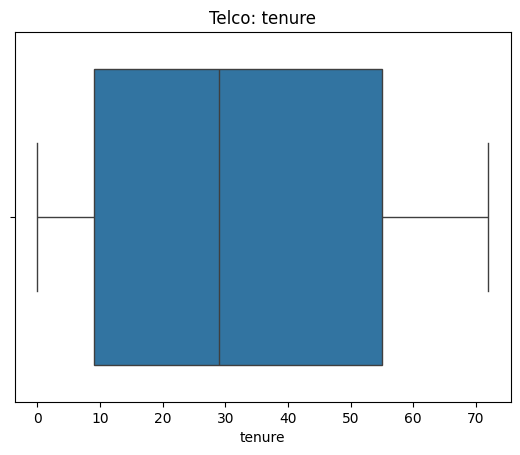

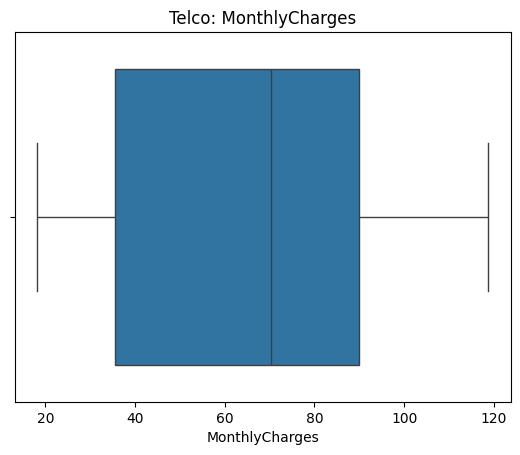

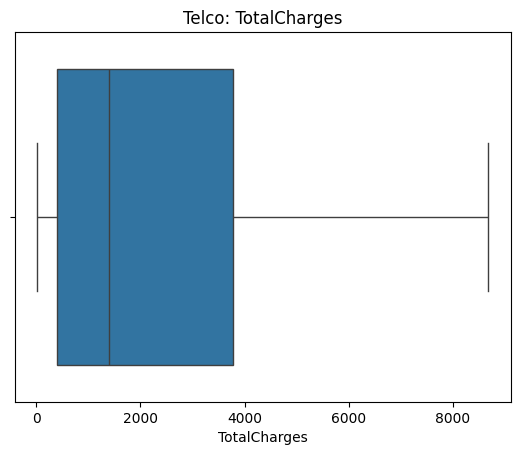

In [4]:
df_telco = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# TotalCharges a float y rellenar nulos
df_telco["TotalCharges"] = pd.to_numeric(df_telco["TotalCharges"], errors="coerce")
df_telco["TotalCharges"] = df_telco["TotalCharges"].fillna(df_telco["TotalCharges"].median())

# Boxplots de numéricas
num_cols_telco = ["tenure", "MonthlyCharges", "TotalCharges"]
for col in num_cols_telco:
    sns.boxplot(x=df_telco[col])
    plt.title(f"Telco: {col}")
    plt.show()

# Normalización z-score
scaler = StandardScaler()
df_telco[num_cols_telco] = scaler.fit_transform(df_telco[num_cols_telco])

# Box-Cox TotalCharges
df_telco["TotalCharges_pos"] = df_telco["TotalCharges"] - df_telco["TotalCharges"].min() + 0.1
pt = PowerTransformer(method="box-cox")
df_telco["TotalCharges_boxcox"] = pt.fit_transform(df_telco[["TotalCharges_pos"]])

# Insurance

In [5]:
df_ins = pd.read_csv("data/insurance.csv")

# Escalado simple de numéricas
num_cols_ins = ["age", "bmi", "charges"]
df_ins[num_cols_ins] = df_ins[num_cols_ins].fillna(df_ins[num_cols_ins].mean())

# EJERCICIO 2: Datos perdidos

In [6]:
print("Telco nulos:\n", df_telco.isnull().sum())
print("Insurance nulos:\n", df_ins.isnull().sum())

Telco nulos:
 customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
TotalCharges_pos       0
TotalCharges_boxcox    0
dtype: int64
Insurance nulos:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# EJERCICIO 3: Correlación y regresión

# Telco

Telco Pearson:
                   tenure  MonthlyCharges  TotalCharges
tenure          1.000000        0.247900      0.825464
MonthlyCharges  0.247900        1.000000      0.650864
TotalCharges    0.825464        0.650864      1.000000
Telco Spearman (tenure vs Churn):
              tenure  Churn_Yes
tenure     1.000000  -0.367062
Churn_Yes -0.367062   1.000000


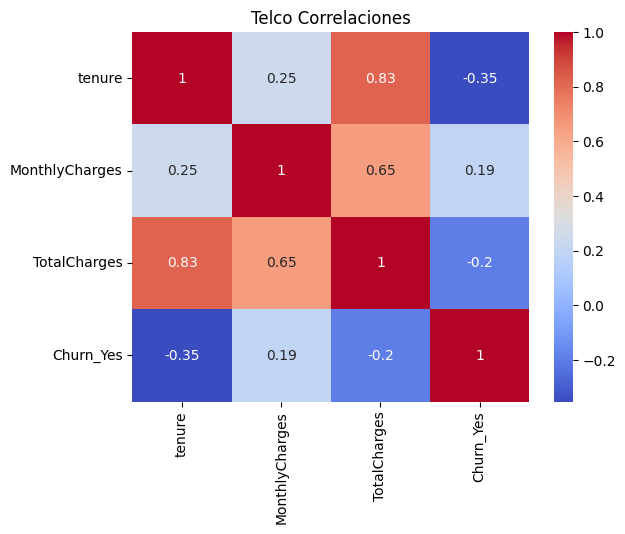

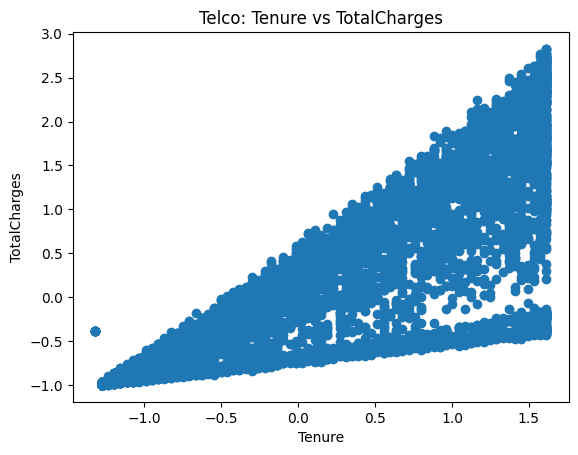

In [7]:
# Churn binario
df_telco["Churn_Yes"] = (df_telco["Churn"]=="Yes").astype(int)

# Correlación Pearson y Spearman
print("Telco Pearson:\n", df_telco[num_cols_telco].corr())
print("Telco Spearman (tenure vs Churn):\n", df_telco[["tenure","Churn_Yes"]].corr(method="spearman"))

# Heatmap
sns.heatmap(df_telco[num_cols_telco + ["Churn_Yes"]].corr(), annot=True, cmap="coolwarm")
plt.title("Telco Correlaciones")
plt.show()

# Scatter tenure vs TotalCharges
plt.scatter(df_telco["tenure"], df_telco["TotalCharges"])
plt.xlabel("Tenure")
plt.ylabel("TotalCharges")
plt.title("Telco: Tenure vs TotalCharges")
plt.show()

# Insurance: regresión lineal

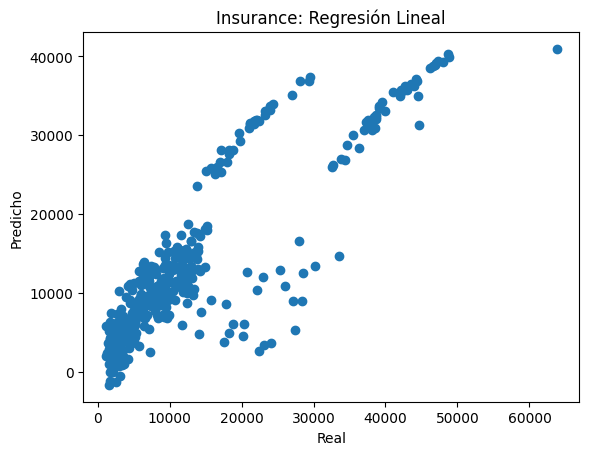

In [8]:
df_ins = pd.get_dummies(df_ins, columns=["sex","smoker","region"], drop_first=True)
X_ins = df_ins.drop("charges", axis=1)
y_ins = df_ins["charges"]

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train_ins, X_test_ins, y_train_ins, y_test_ins = train_test_split(X_ins, y_ins, test_size=0.3, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train_ins, y_train_ins)
y_pred_ins = linreg.predict(X_test_ins)

plt.scatter(y_test_ins, y_pred_ins)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Insurance: Regresión Lineal")
plt.show()

# EJERCICIO 4: Partición y métricas

Telco Accuracy: 0.7879791765262659
Telco AUC: 0.8164549910873441
Telco Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1552
           1       0.63      0.48      0.54       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.78      0.79      0.78      2113



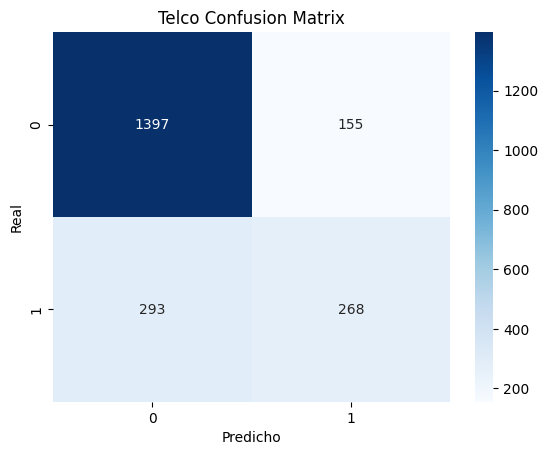

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Telco: eliminar texto y convertir categóricas a dummies
df_telco_ml = df_telco.drop(columns=["customerID", "Churn"])
cat_cols_telco = df_telco_ml.select_dtypes(include="object").columns
df_telco_ml = pd.get_dummies(df_telco_ml, columns=cat_cols_telco, drop_first=True)

X_telco_ml = df_telco_ml.drop("Churn_Yes", axis=1)
y_telco_ml = df_telco_ml["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(
    X_telco_ml, y_telco_ml, test_size=0.3, random_state=42, stratify=y_telco_ml
)

rf_telco = RandomForestClassifier(n_estimators=50, random_state=42)
rf_telco.fit(X_train, y_train)

y_pred = rf_telco.predict(X_test)
y_proba = rf_telco.predict_proba(X_test)[:,1]

print("Telco Accuracy:", accuracy_score(y_test, y_pred))
print("Telco AUC:", roc_auc_score(y_test, y_proba))
print("Telco Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Telco Confusion Matrix")
plt.show()